
# Capstone Project - The Battle of Neighbourhoods

## Introduction

New Delhi is the capital city of India. It is a part of the city of Delhi’s 11 districts. The city itself has a population of 257,803. However, the much larger metro area has a population that exceeds 26 million.

New Delhi are used interchangeably to refer to the National Capital Territory of Delhi (NCT), these are two distinct entities, with New Delhi forming a small part of Delhi. The National Capital Region is a much larger entity comprising the entire NCT along with adjoining districts in neighboring states.

The official language of New Delhi and the one that is most widely spoken is Hindi. However, English is also spoken as a formal language within businesses and government agencies. Over last decades it is continuously grow because of the city’s important role in government and commercial business.

With it’s diverse culture , comes diverse food items. There are many restaurants in New Delhi City, each belonging to different categories like Chinese , Italian , French etc. So as part of this project , we will list and visualise all major parts of New Delhi City.

## Business Problem

- What is best location in New Delhi City for Chinese Cuisine ?
- Which areas have large number of Chinese Resturant Market ?
- Which all areas have less number of resturant ?
- Which is the best place to stay if I prefer Chinese Cuisine ?
- What places are have best restaurant in New Delhi?

## Data

For this project we need the following data :

- New Delhi Resturants data that contains list Locality, Resturant name,Rating along with their latitude and longitude.
    - Data source : [Zomato kaggel dataset](https://www.kaggle.com/shrutimehta/zomato-restaurants-data)
    - Description : This data set contains the required information. And we will use this data set to explore various locality of new delhi city.
    
- Nearby places in each locality of new delhi city.
    - Data source : [Fousquare API](https://developer.foursquare.com/)
    - Description : By using this api we will get all the venues in each neighborhood.
    
## Approach
- Collect the new delhi city data from Zomato kaggel dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are nearby by locality.
- Using aggregative rating for each resturant to find the best places.
- Visualize the Ranking of neighborhoods using folium library(python)

In [1]:
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup
import requests
import pandas as pd # library for data analsysis

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import geocoder

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/SaiManojReddy/Capstone-Project---The-Battle-of-Neighborhoods/main/zomato.csv',encoding='ISO-8859-1')
df.head()

Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mandaluyong City   
3      SM Megamall, Ortigas, Mandaluyong City   
4      SM Megamall, Ortigas, Mandaluyong City   

                                    Locality Verbose   Longitude   Latitude  \
0  Century City Mall, Poblacion, Makati City, Mak...  121.027535  14.565443   
1  Little Tokyo, Legaspi Village, Makati City, Ma...  121.014101  14.553708   
2  Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...  121.056831  14.581404   
3  SM Megamall, Ortigas, Mandaluyong City, Mandal...  121.056475  14.585318   
4  SM Megamall, Ortigas, Mandaluyong City, Mandal...  121.057508  14.584450   

                           Cuisines  ...          Currency Has Table booking  \
0        French, Japanese, Desserts  ...  Botswana Pula(P)               Yes   
1                          Japanese  ...  Botswana Pula(P)               Yes   
2  Seafood, Asian, Filipino, Indian  ...  Botswana Pula(P)               Yes   
3                   Japanese, Sushi  ...  Botswana Pula(P)                No   
4                  Japanese, Korean  ...  Botswana Pula(P)               Yes   

  Has Online delivery Is delivering now Switch to order menu Price range  \
0                  No                No                   No           3   
1                  No                No                   No           3   
2                  No                No                   No           4   
3                  No                No                   No           4   
4                  No                No                   No           4   

   Aggregate rating  Rating color Rating text Votes  
0               4.8    Dark Green   Excellent   314  
1               4.5    Dark Green   Excellent   591  
2               4.4         Green   Very Good   270  
3               4.9    Dark Green   Excellent   365  
4               4.8    Dark Green   Excellent   229  

[5 rows x 21 columns]

In [3]:
df_india = df[df['Country Code'] == 1]
df_NDLS = df_india[df_india['City'] == 'New Delhi']
df_NDLS.reset_index(drop=True, inplace=True)
df_NDLS.head()

Restaurant ID  Restaurant Name  Country Code       City  \
0       18287358       Food Cloud             1  New Delhi   
1       18216944        Burger.in             1  New Delhi   
2         313333  Days of the Raj             1  New Delhi   
3       18384127   Dilli Ka Dhaba             1  New Delhi   
4            582        Govardhan             1  New Delhi   

                                             Address    Locality  \
0                              Aaya Nagar, New Delhi  Aaya Nagar   
1        84, Near Honda Showroom, Adchini, New Delhi     Adchini   
2  81/3, 1st Floor, Qutub Residency, Adchini, New...     Adchini   
3  66 A, Ground Floor, Sri Aurobindo Marg, Adchin...     Adchini   
4  84, Adjacent Hero Motor Bike Showroom, Main Me...     Adchini   

        Locality Verbose  Longitude   Latitude  \
0  Aaya Nagar, New Delhi   0.000000   0.000000   
1     Adchini, New Delhi  77.196923  28.535382   
2     Adchini, New Delhi  77.197475  28.535493   
3     Adchini, New Delhi  77.198033  28.537547   
4     Adchini, New Delhi  77.196924  28.535523   

                              Cuisines  ...            Currency  \
0                       Cuisine Varies  ...  Indian Rupees(Rs.)   
1                            Fast Food  ...  Indian Rupees(Rs.)   
2   North Indian, Seafood, Continental  ...  Indian Rupees(Rs.)   
3           South Indian, North Indian  ...  Indian Rupees(Rs.)   
4  South Indian, North Indian, Chinese  ...  Indian Rupees(Rs.)   

  Has Table booking Has Online delivery Is delivering now  \
0                No                  No                No   
1                No                 Yes                No   
2               Yes                 Yes                No   
3                No                  No                No   
4                No                 Yes                No   

  Switch to order menu Price range  Aggregate rating  Rating color  \
0                   No           2               0.0         White   
1                   No           1               3.2        Orange   
2                   No           3               3.4        Orange   
3                   No           2               2.6        Orange   
4                   No           2               3.4        Orange   

  Rating text Votes  
0   Not rated     2  
1     Average    46  
2     Average    45  
3     Average    11  
4     Average   238  

[5 rows x 21 columns]

## Data Cleaning

In [4]:
df_Res= df_NDLS[df_NDLS.Longitude !=0.000000][['Restaurant Name','Locality','Longitude','Latitude','Cuisines','Aggregate rating','Rating text','Votes']]
df_Res = df_Res[df_Res['Aggregate rating'] !=0.0]
df_Res.head()

Restaurant Name Locality  Longitude   Latitude  \
1        Burger.in  Adchini  77.196923  28.535382   
2  Days of the Raj  Adchini  77.197475  28.535493   
3   Dilli Ka Dhaba  Adchini  77.198033  28.537547   
4        Govardhan  Adchini  77.196924  28.535523   
5   Mezbaan Grills  Adchini  77.198122  28.538134   

                              Cuisines  Aggregate rating Rating text  Votes  
1                            Fast Food               3.2     Average     46  
2   North Indian, Seafood, Continental               3.4     Average     45  
3           South Indian, North Indian               2.6     Average     11  
4  South Indian, North Indian, Chinese               3.4     Average    238  
5                              Mughlai               3.1     Average      8

### created map to show the restaurant cluters

In [5]:
New_Delhi_Rest = folium.Map(location=[28.52, 77.25], zoom_start=12)

X = df_Res['Latitude']
Y = df_Res['Longitude']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=5, random_state=0).fit(Z)

clusters = kmeans.labels_
colors = ['red', 'green', 'blue', 'yellow','orange']
df_Res ['Cluster'] = clusters

for latitude, longitude, Locality, cluster in zip(df_Res['Latitude'], df_Res['Longitude'], df_Res['Locality'], df_Res['Cluster']):
    label = folium.Popup(Locality, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(New_Delhi_Rest)  

New_Delhi_Rest

In [6]:
df_Res.head()

Restaurant Name Locality  Longitude   Latitude  \
1        Burger.in  Adchini  77.196923  28.535382   
2  Days of the Raj  Adchini  77.197475  28.535493   
3   Dilli Ka Dhaba  Adchini  77.198033  28.537547   
4        Govardhan  Adchini  77.196924  28.535523   
5   Mezbaan Grills  Adchini  77.198122  28.538134   

                              Cuisines  Aggregate rating Rating text  Votes  \
1                            Fast Food               3.2     Average     46   
2   North Indian, Seafood, Continental               3.4     Average     45   
3           South Indian, North Indian               2.6     Average     11   
4  South Indian, North Indian, Chinese               3.4     Average    238   
5                              Mughlai               3.1     Average      8   

   Cluster  
1        1  
2        1  
3        1  
4        1  
5        1

## What places are have best restaurant in New Delhi?

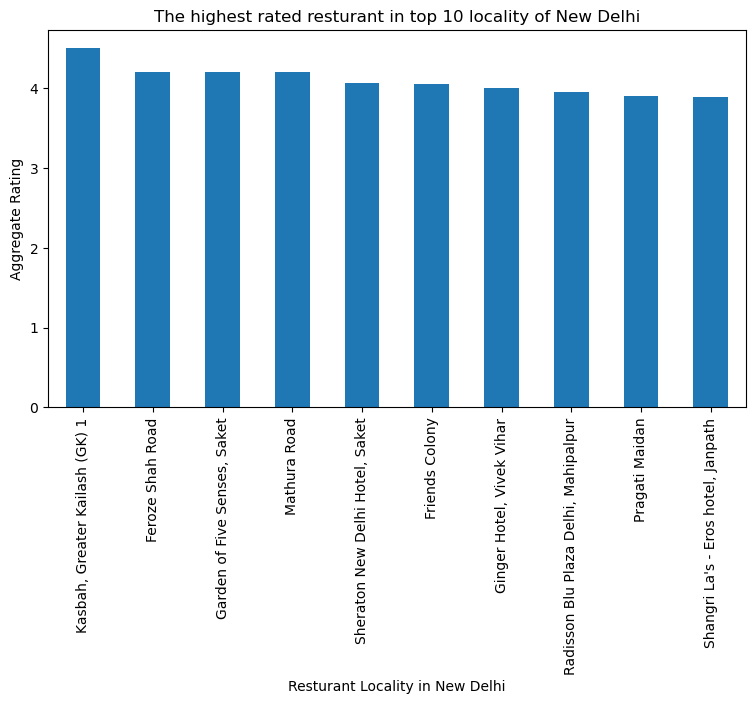

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The highest rated resturant in top 10 locality of New Delhi')
#On x-axis

#giving a bar plot
df_Res.groupby('Locality')['Aggregate rating'].mean().nlargest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Aggregate Rating')
#displays the plot
plt.show()

## what places are have worst restaurants in New Delhi?

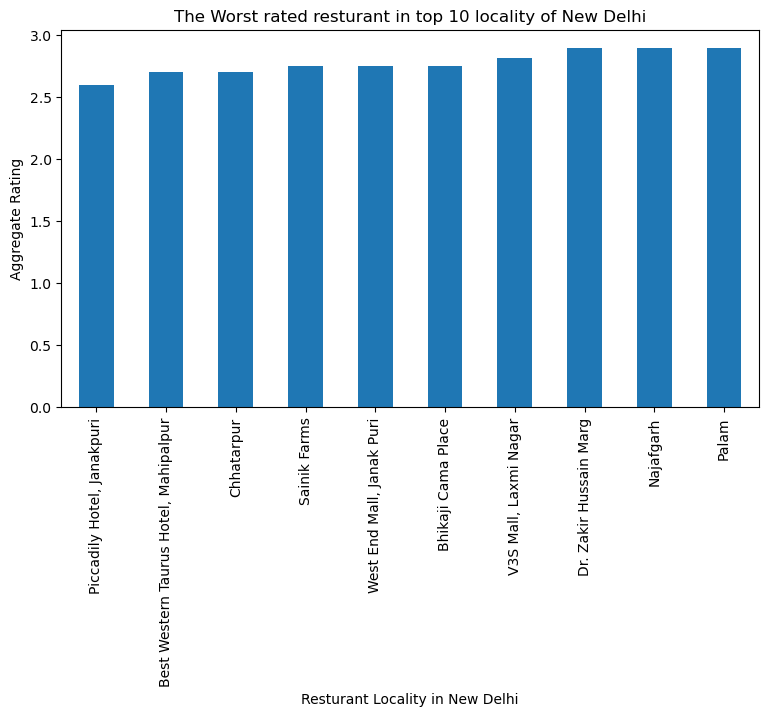

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The Worst rated resturant in top 10 locality of New Delhi')
#On x-axis

#giving a bar plot

df_Res.groupby('Locality')['Aggregate rating'].mean().nsmallest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Aggregate Rating')

#displays the plot
plt.show()

## Which place are suitable for edible person in New Delhi city?

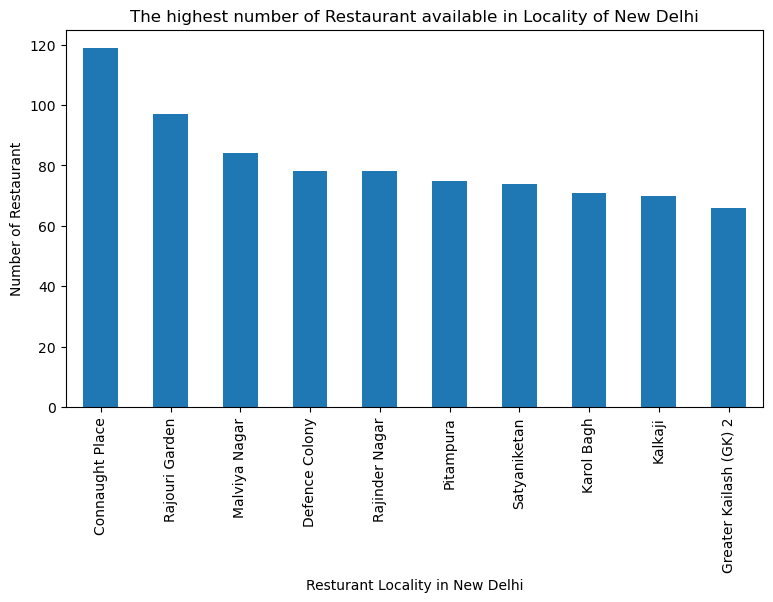

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The highest number of Restaurant available in Locality of New Delhi')
#On x-axis

#giving a bar plot
df_Res.groupby('Locality')['Restaurant Name'].count().nlargest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Number of Restaurant')

#displays the plot
plt.show()

## Which place are not suitable for edible person in New Delhi city?

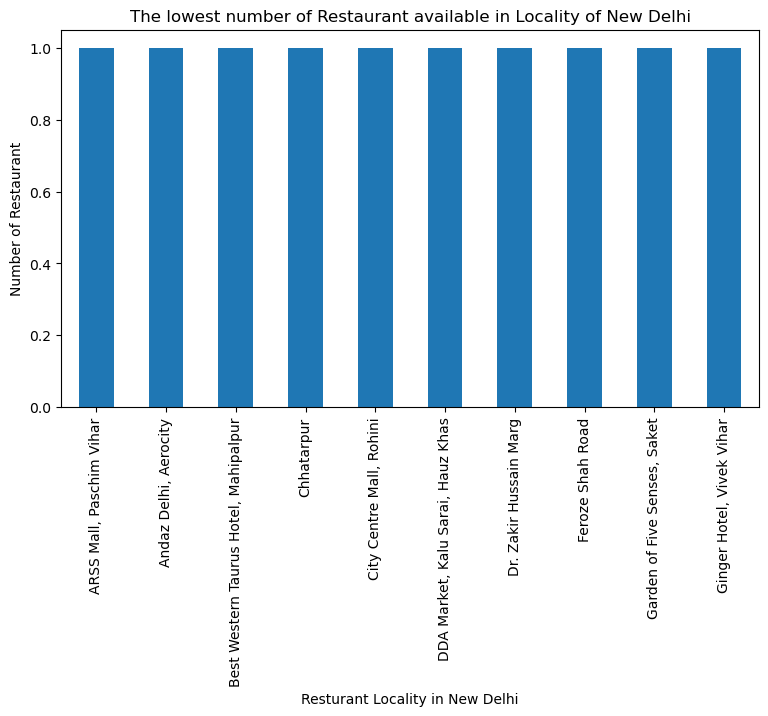

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The lowest number of Restaurant available in Locality of New Delhi')
#On x-axis

#giving a bar plot
df_Res.groupby('Locality')['Restaurant Name'].count().nsmallest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Number of Restaurant')

#displays the plot
plt.show()

## What are the best places for chinese restaurant in New Delhi city

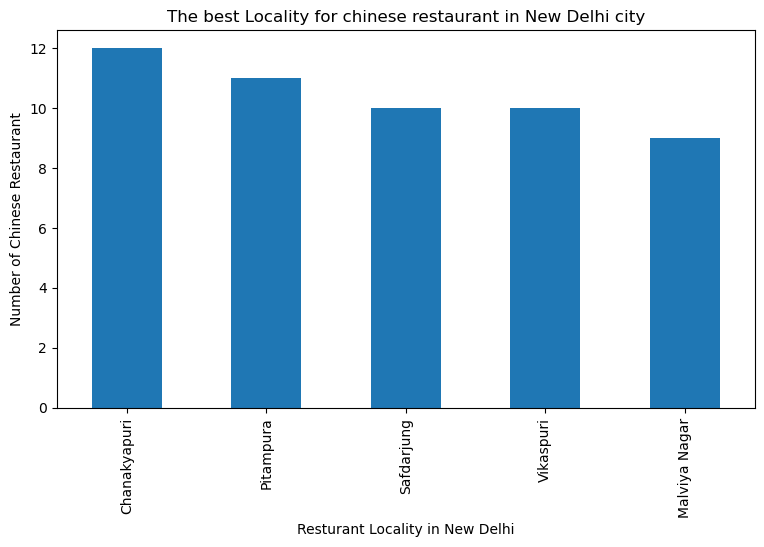

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The best Locality for chinese restaurant in New Delhi city')
#On x-axis

#giving a bar plot
df_Res[df_Res['Cuisines'].str.startswith('Chinese')].groupby('Locality')['Restaurant Name'].count().nlargest(5).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Number of Chinese Restaurant')

#displays the plot
plt.show()

## which places are the best chinese resturants in New Delhi?

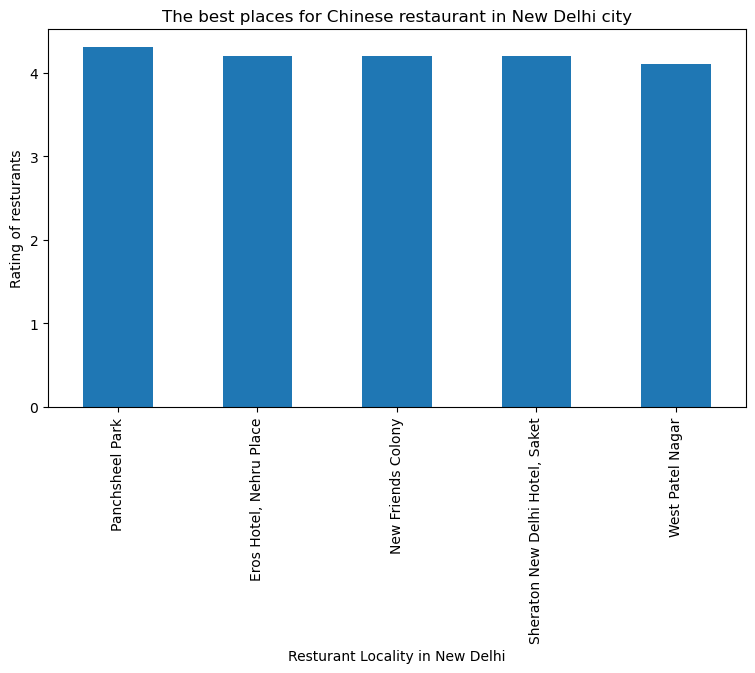

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The best places for Chinese restaurant in New Delhi city')
#On x-axis

#giving a bar plot
df_Res[df_Res['Cuisines'].str.startswith('Chinese')].groupby('Locality')['Aggregate rating'].mean().nlargest(5).plot(kind='bar')

plt.xlabel('Resturant Locality in New Delhi')
#On y-axis
plt.ylabel('Rating of resturants')

#displays the plot
plt.show()

## Data transformation

In [13]:
df_Res_Loc =  df_Res.groupby('Locality').count()['Restaurant Name'].to_frame()
df_Res_rating= df_Res.groupby('Locality')['Aggregate rating'].mean().to_frame()
d_Cuisines = df_Res.groupby(['Locality'])['Cuisines'].agg(', '.join).reset_index()
d_R = df_Res.groupby(['Locality'])['Rating text'].unique().agg(', '.join).reset_index()
d_V = df_Res.groupby(['Locality'])['Votes'].sum().to_frame()
d_Lat = df_Res.groupby('Locality').mean()['Latitude'].to_frame()
d_Lng = df_Res.groupby('Locality').mean()['Longitude'].to_frame()
df_final = pd.merge(d_Lat,d_Lng,on='Locality').merge(df_Res_Loc, on='Locality').merge(d_Cuisines, on='Locality').merge(df_Res_rating,on ='Locality').merge(d_R, on ='Locality').merge(d_V, on ='Locality')
df_final = df_final[df_final['Aggregate rating'] != 0.000000]
df_final.columns =['Locality','Lat','Lng', 'No_of_Restaurant','Cusines', 'Agg_Rating','Comments' ,'No_of_Votes']
df_final.head()

Locality        Lat        Lng  No_of_Restaurant  \
0       ARSS Mall, Paschim Vihar  28.668945  77.101544                 1   
1                        Adchini  28.537063  77.197808                13   
2  Aditya Mega Mall, Karkardooma  28.656131  77.301266                 4   
3                       Aerocity  28.553077  77.104270                 2   
4  Aggarwal City Mall, Pitampura  28.690020  77.134650                 3   

                                             Cusines  Agg_Rating  \
0  North Indian, South Indian, Chinese, Mithai, F...    3.100000   
1  Fast Food, North Indian, Seafood, Continental,...    3.292308   
2  Finger Food, North Indian, Mughlai, Pizza, Fas...    3.275000   
3  Fast Food, Italian, Pizza, North Indian, Conti...    3.200000   
4  North Indian, Chinese, Street Food, Mithai, No...    3.033333   

                         Comments  No_of_Votes  
0                         Average          117  
1  Average, Good, Poor, Very Good         1560  
2                   Average, Good          434  
3                         Average           59  
4                         Average          126

In [14]:
df_final.shape

(240, 8)

# Define Foursquare Credentials and Version

In [15]:
## Define Foursquare Credentials and Version
CLIENT_ID = 'XLBDRGURZVOOULUGDUC4DSJZSRE5ZI0XPB1WA5RV3YL5D1TP' # Foursquare ID
CLIENT_SECRET = '5TW0I4L1WKC5A0H1NZHEDZD535BFN1CDQ2MRHBW1VBNFUTEK' # Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XLBDRGURZVOOULUGDUC4DSJZSRE5ZI0XPB1WA5RV3YL5D1TP
CLIENT_SECRET:5TW0I4L1WKC5A0H1NZHEDZD535BFN1CDQ2MRHBW1VBNFUTEK


## create a function to repeat the same process to all the Locality in New Delhi

In [16]:
## create a function to repeat the same process to all the Locality in New Delhi

def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Locality', 
                  'Locality Latitude', 
                  'Locality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## find the venues in all New Delhi Locality

In [17]:
# find the venues in all New Delhi Locality
new_Delhi_venues = getNearbyVenues(names=df_final['Locality'],
                                   latitudes=df_final['Lat'],
                                   longitudes=df_final['Lng']
                                  )

ARSS Mall, Paschim Vihar
Adchini
Aditya Mega Mall, Karkardooma
Aerocity
Aggarwal City Mall, Pitampura
Aggarwal City Plaza, Rohini
Alaknanda
Ambience Mall, Vasant Kunj
Anand Lok
Anand Vihar
Andaz Delhi, Aerocity
Ansal Plaza Mall, Khel Gaon Marg
Asaf Ali Road
Ashok Vihar Phase 1
Ashok Vihar Phase 2
Ashok Vihar Phase 3
Barakhamba Road
Basant Lok Market, Vasant Vihar
Bellagio, Ashok Vihar Phase 2
Best Western Taurus Hotel, Mahipalpur
Bhikaji Cama Place
Chanakyapuri
Chander Nagar
Chandni Chowk
Chawri Bazar
Chhatarpur
Chittaranjan Park
City Centre Mall, Rohini
City Square Mall, Rajouri Garden
Civil Lines
Community Centre, New Friends Colony
Connaught Place
Crescent Square Mall, Rohini
Cross River Mall, Karkardooma
Crowne Plaza Hotel, Rohini
Crowne Plaza, Mayur Vihar Phase 1
D Mall, Netaji Subhash Place
DDA Market, Kalu Sarai, Hauz Khas
DLF City Centre Mall, Shalimar Bagh
DLF Emporio Mall, Vasant Kunj
DLF Place Mall, Saket
DLF Promenade Mall, Vasant Kunj
DLF South Square, Sarojini Nagar
Darya

In [18]:
new_Delhi_venues.head()

Locality  Locality Latitude  Locality Longitude  \
0  ARSS Mall, Paschim Vihar          28.668945           77.101544   
1  ARSS Mall, Paschim Vihar          28.668945           77.101544   
2  ARSS Mall, Paschim Vihar          28.668945           77.101544   
3  ARSS Mall, Paschim Vihar          28.668945           77.101544   
4  ARSS Mall, Paschim Vihar          28.668945           77.101544   

                         Venue  Venue Latitude  Venue Longitude  \
0                       Subway       28.669999        77.102546   
1                    Pizza Hut       28.670321        77.103853   
2              Café Coffee Day       28.670009        77.102480   
3  Baljeet's Amritsari Koolcha       28.665768        77.100481   
4                  Little Chef       28.670000        77.101459   

       Venue Category  
0      Sandwich Place  
1         Pizza Place  
2         Coffee Shop  
3   Indian Restaurant  
4  Chinese Restaurant

In [19]:
new_Delhi_venues.groupby('Locality').count()

Locality Latitude  Locality Longitude  Venue  \
Locality                                                                       
ARSS Mall, Paschim Vihar                        9                   9      9   
Adchini                                         8                   8      8   
Aditya Mega Mall, Karkardooma                  10                  10     10   
Aerocity                                        7                   7      7   
Aggarwal City Mall, Pitampura                   4                   4      4   
...                                           ...                 ...    ...   
West Gate Mall, Rajouri Garden                 16                  16     16   
West Patel Nagar                                5                   5      5   
Worldmark 1, Aerocity                          29                  29     29   
Yusuf Sarai                                    13                  13     13   
ibis New Delhi, Aerocity                       27                  27     27   

                                Venue Latitude  Venue Longitude  \
Locality                                                          
ARSS Mall, Paschim Vihar                     9                9   
Adchini                                      8                8   
Aditya Mega Mall, Karkardooma               10               10   
Aerocity                                     7                7   
Aggarwal City Mall, Pitampura                4                4   
...                                        ...              ...   
West Gate Mall, Rajouri Garden              16               16   
West Patel Nagar                             5                5   
Worldmark 1, Aerocity                       29               29   
Yusuf Sarai                                 13               13   
ibis New Delhi, Aerocity                    27               27   

                                Venue Category  
Locality                                        
ARSS Mall, Paschim Vihar                     9  
Adchini                                      8  
Aditya Mega Mall, Karkardooma               10  
Aerocity                                     7  
Aggarwal City Mall, Pitampura                4  
...                                        ...  
West Gate Mall, Rajouri Garden              16  
West Patel Nagar                             5  
Worldmark 1, Aerocity                       29  
Yusuf Sarai                                 13  
ibis New Delhi, Aerocity                    27  

[239 rows x 6 columns]

In [20]:
print('There are {} uniques categories.'.format(len(new_Delhi_venues['Venue Category'].unique())))

There are 206 uniques categories.


In [21]:
## Analyze Each Locality

# one hot encoding
new_Delhi_onehot = pd.get_dummies(new_Delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add Locality column back to dataframe
new_Delhi_onehot['Locality'] = new_Delhi_venues['Locality'] 

# move Locality column to the first column
column_list = new_Delhi_onehot.columns.tolist()
column_number = int(column_list.index('Locality'))
column_list = [column_list[column_number]] + column_list[:column_number] + column_list[column_number+1:]
new_Delhi_onehot = new_Delhi_onehot[column_list]

new_Delhi_onehot.head()

Locality  ATM  Accessories Store  Afghan Restaurant  \
0  ARSS Mall, Paschim Vihar    0                  0                  0   
1  ARSS Mall, Paschim Vihar    0                  0                  0   
2  ARSS Mall, Paschim Vihar    0                  0                  0   
3  ARSS Mall, Paschim Vihar    0                  0                  0   
4  ARSS Mall, Paschim Vihar    0                  0                  0   

   African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Arcade  ...  Trail  Train Station  Turkish Restaurant  \
0                    0       0  ...      0              0                   0   
1                    0       0  ...      0              0                   0   
2                    0       0  ...      0              0                   0   
3                    0       0  ...      0              0                   0   
4                    0       0  ...      0              0                   0   

   Udupi Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                 0                              0                      0   
1                 0                              0                      0   
2                 0                              0                      0   
3                 0                              0                      0   
4                 0                              0                      0   

   Whisky Bar  Wine Bar  Wings Joint  Women's Store  
0           0         0            0              0  
1           0         0            0              0  
2           0         0            0              0  
3           0         0            0              0  
4           0         0            0              0  

[5 rows x 207 columns]

In [22]:
New_Delhi_grouped = new_Delhi_onehot.groupby('Locality').mean().reset_index()
New_Delhi_grouped

Locality       ATM  Accessories Store  \
0          ARSS Mall, Paschim Vihar  0.111111           0.000000   
1                           Adchini  0.000000           0.000000   
2     Aditya Mega Mall, Karkardooma  0.000000           0.000000   
3                          Aerocity  0.000000           0.000000   
4     Aggarwal City Mall, Pitampura  0.000000           0.000000   
..                              ...       ...                ...   
234  West Gate Mall, Rajouri Garden  0.000000           0.000000   
235                West Patel Nagar  0.000000           0.000000   
236           Worldmark 1, Aerocity  0.000000           0.034483   
237                     Yusuf Sarai  0.000000           0.000000   
238        ibis New Delhi, Aerocity  0.000000           0.000000   

     Afghan Restaurant  African Restaurant  Airport Lounge  Airport Service  \
0                  0.0                 0.0        0.000000              0.0   
1                  0.0                 0.0        0.000000              0.0   
2                  0.0                 0.0        0.000000              0.0   
3                  0.0                 0.0        0.142857              0.0   
4                  0.0                 0.0        0.000000              0.0   
..                 ...                 ...             ...              ...   
234                0.0                 0.0        0.000000              0.0   
235                0.0                 0.0        0.000000              0.0   
236                0.0                 0.0        0.000000              0.0   
237                0.0                 0.0        0.000000              0.0   
238                0.0                 0.0        0.000000              0.0   

     Airport Terminal  American Restaurant  Arcade  ...  Trail  Train Station  \
0            0.000000               0.0000     0.0  ...    0.0       0.000000   
1            0.000000               0.0000     0.0  ...    0.0       0.000000   
2            0.000000               0.0000     0.0  ...    0.0       0.000000   
3            0.142857               0.0000     0.0  ...    0.0       0.000000   
4            0.000000               0.0000     0.0  ...    0.0       0.000000   
..                ...                  ...     ...  ...    ...            ...   
234          0.000000               0.0625     0.0  ...    0.0       0.000000   
235          0.000000               0.0000     0.0  ...    0.0       0.000000   
236          0.000000               0.0000     0.0  ...    0.0       0.034483   
237          0.000000               0.0000     0.0  ...    0.0       0.000000   
238          0.000000               0.0000     0.0  ...    0.0       0.037037   

     Turkish Restaurant  Udupi Restaurant  Vegetarian / Vegan Restaurant  \
0                   0.0               0.0                            0.0   
1                   0.0               0.0                            0.0   
2                   0.0               0.0                            0.0   
3                   0.0               0.0                            0.0   
4                   0.0               0.0                            0.0   
..                  ...               ...                            ...   
234                 0.0               0.0                            0.0   
235                 0.0               0.0                            0.0   
236                 0.0               0.0                            0.0   
237                 0.0               0.0                            0.0   
238                 0.0               0.0                            0.0   

     Vietnamese Restaurant  Whisky Bar  Wine Bar  Wings Joint  Women's Store  
0                      0.0         0.0       0.0          0.0            0.0  
1                      0.0         0.0       0.0          0.0            0.0  
2                      0.0         0.0       0.0          0.0            0.0  
3                      0.0         0.0       0.0          0

In [23]:
New_Delhi_grouped.shape

(239, 207)

In [24]:
## print each Locality along with the top 5 most common venues

num_top_venues = 5

for hood in New_Delhi_grouped['Locality']:
    print("----"+hood+"----")
    temp = New_Delhi_grouped[New_Delhi_grouped['Locality'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ARSS Mall, Paschim Vihar----
                venue  freq
0   Indian Restaurant  0.22
1                 ATM  0.11
2              Market  0.11
3         Coffee Shop  0.11
4  Chinese Restaurant  0.11


----Adchini----
               venue  freq
0  Indian Restaurant  0.25
1               Café  0.25
2   Parsi Restaurant  0.12
3                Pub  0.12
4              Hotel  0.12


----Aditya Mega Mall, Karkardooma----
               venue  freq
0        Pizza Place   0.2
1  Indian Restaurant   0.2
2          Multiplex   0.2
3      Shopping Mall   0.2
4              Hotel   0.1


----Aerocity----
                  venue  freq
0                 Hotel  0.29
1   Rental Car Location  0.14
2  Fast Food Restaurant  0.14
3        Airport Lounge  0.14
4           Coffee Shop  0.14


----Aggarwal City Mall, Pitampura----
                venue  freq
0   Indian Restaurant  0.50
1         Pizza Place  0.25
2    Department Store  0.25
3  Italian Restaurant  0.00
4       Moving Target  0.00


----Agga

                  venue  freq
0           Coffee Shop  0.07
1    Chinese Restaurant  0.07
2  Fast Food Restaurant  0.07
3                 Hotel  0.03
4    Frozen Yogurt Shop  0.03


----Eros Hotel, Nehru Place----
                  venue  freq
0  Fast Food Restaurant  0.12
1           Coffee Shop  0.08
2        Sandwich Place  0.04
3    Bengali Restaurant  0.04
4            Restaurant  0.04


----Essex Farms----
           venue  freq
0    Coffee Shop  0.25
1    Event Space  0.25
2      Nightclub  0.25
3  Metro Station  0.25
4            ATM  0.00


----Feroze Shah Road----
               venue  freq
0  Indian Restaurant  0.67
1               Park  0.33
2                ATM  0.00
3          Nightclub  0.00
4      Moving Target  0.00


----Friends Colony----
              venue  freq
0             Hotel   0.4
1  Sculpture Garden   0.2
2               Gym   0.2
3              Café   0.2
4               ATM   0.0


----GTB Nagar----
                      venue  freq
0               Pizza 

                        venue  freq
0           Indian Restaurant  0.13
1          Italian Restaurant  0.07
2                    Tea Room  0.07
3  Modern European Restaurant  0.07
4                  Restaurant  0.07


----Lodhi Road----
                       venue  freq
0                      Diner  0.06
1                     Temple  0.06
2         Italian Restaurant  0.06
3          Indian Restaurant  0.06
4  Middle Eastern Restaurant  0.06


----MG Road----
                    venue  freq
0       Indian Restaurant  0.33
1  Furniture / Home Store  0.33
2              Art Museum  0.33
3                     ATM  0.00
4               Nightclub  0.00


----MGF Metropolitan Mall, Saket----
                venue  freq
0   Indian Restaurant  0.12
1              Lounge  0.07
2      Clothing Store  0.07
3                 Bar  0.07
4  Chinese Restaurant  0.06


----MGM Club, Daryaganj----
               venue  freq
0  Indian Restaurant  0.33
1         Restaurant  0.33
2               Road  0.1

                 venue  freq
0                Hotel  0.35
1          Coffee Shop  0.08
2  Japanese Restaurant  0.04
3           Hotel Pool  0.04
4                  Spa  0.04


----Punjabi Bagh----
               venue  freq
0         Hookah Bar  0.17
1         Donut Shop  0.17
2  Indian Restaurant  0.17
3  Convenience Store  0.17
4        Coffee Shop  0.17


----Qutab Institutional Area----
                        venue  freq
0           Indian Restaurant  0.25
1                  Restaurant  0.25
2         Moroccan Restaurant  0.12
3                  Food Truck  0.12
4  Modern European Restaurant  0.12


----R K Puram----
                     venue  freq
0               Restaurant  0.14
1                Multiplex  0.14
2                     Park  0.14
3            Shopping Mall  0.14
4  Comfort Food Restaurant  0.14


----Race Course----
                  venue  freq
0         Women's Store   0.2
1        History Museum   0.2
2             Racetrack   0.2
3                  Food   0.2


                           venue  freq
0                   Dessert Shop  0.14
1  Vegetarian / Vegan Restaurant  0.14
2           Fast Food Restaurant  0.14
3             Chinese Restaurant  0.14
4                            Bar  0.14


----Vasant Square Mall, Vasant Kunj----
                  venue  freq
0                   Spa  0.11
1                  Bank  0.11
2          Dessert Shop  0.11
3  Fast Food Restaurant  0.11
4    Chinese Restaurant  0.11


----Vasant Vihar----
                  venue  freq
0                  Café  0.11
1           Pizza Place  0.07
2  Fast Food Restaurant  0.07
3            Restaurant  0.07
4           Coffee Shop  0.07


----Vasundhara Enclave----
                            venue  freq
0                            Café   1.0
1                             ATM   0.0
2                     Pizza Place   0.0
3              Mughlai Restaurant   0.0
4  Multicuisine Indian Restaurant   0.0


----Vijay Nagar----
                venue  freq
0                Café 

In [25]:
## put that into a pandas dataframe
## First, write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
## create the new dataframe and display the top 10 venues for each Locality.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Locality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Locality_venues_sorted = pd.DataFrame(columns=columns)
Locality_venues_sorted['Locality'] = New_Delhi_grouped['Locality']

for ind in np.arange(New_Delhi_grouped.shape[0]):
    Locality_venues_sorted.iloc[ind, 1:] = return_most_common_venues(New_Delhi_grouped.iloc[ind, :], num_top_venues)

Locality_venues_sorted

Locality 1st Most Common Venue  \
0          ARSS Mall, Paschim Vihar     Indian Restaurant   
1                           Adchini     Indian Restaurant   
2     Aditya Mega Mall, Karkardooma     Indian Restaurant   
3                          Aerocity                 Hotel   
4     Aggarwal City Mall, Pitampura     Indian Restaurant   
..                              ...                   ...   
234  West Gate Mall, Rajouri Garden                  Café   
235                West Patel Nagar                 Hotel   
236           Worldmark 1, Aerocity                 Hotel   
237                     Yusuf Sarai     Indian Restaurant   
238        ibis New Delhi, Aerocity                 Hotel   

    2nd Most Common Venue 3rd Most Common Venue  \
0          Sandwich Place                Market   
1                    Café      Parsi Restaurant   
2           Shopping Mall           Pizza Place   
3     Rental Car Location        Airport Lounge   
4             Pizza Place      Department Store   
..                    ...                   ...   
234  Fast Food Restaurant   American Restaurant   
235           Pizza Place                Bakery   
236       Bed & Breakfast           Coffee Shop   
237           Coffee Shop     Korean Restaurant   
238           Coffee Shop             Hotel Bar   

              4th Most Common Venue 5th Most Common Venue  \
0    Multicuisine Indian Restaurant           Pizza Place   
1                             Hotel                   Pub   
2                         Multiplex                 Hotel   
3                  Airport Terminal           Coffee Shop   
4                Falafel Restaurant   Fried Chicken Joint   
..                              ...                   ...   
234              Chinese Restaurant            Restaurant   
235            Gym / Fitness Center         Women's Store   
236              Italian Restaurant                Lounge   
237                    Dessert Shop        Ice Cream Shop   
238                 Thai Restaurant            Hotel Pool   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0             Coffee Shop    Chinese Restaurant                   ATM   
1             Coffee Shop    Falafel Restaurant            Food Truck   
2                    Café        Farmers Market            Food Truck   
3    Fast Food Restaurant    Falafel Restaurant   Fried Chicken Joint   
4       French Restaurant            Food Truck            Food Court   
..                    ...                   ...                   ...   
234             Multiplex           Pizza Place           Snack Place   
235    Falafel Restaurant     French Restaurant            Food Truck   
236    Punjabi Restaurant                Bakery                   Gym   
237                   Bar                Lounge      Asian Restaurant   
238    Punjabi Restaurant            Restaurant         Shopping Mall   

    9th Most Common Venue 10th Most Common Venue  
0     American Restaurant                  Diner  
1              Food Court      Food & Drink Shop  
2              Food Court      Food & Drink Shop  
3       French Restaurant             Food Truck  
4       Food & Drink Shop                   Food  
..                    ...                    ...  
234            Shoe Store         Cosmetics Shop  
235            Food Court      Food & Drink Shop  
236       Thai Restaurant          Shopping Mall  
237                  Park    Japanese Restaurant  
238                   Spa        Bed & Breakfast  

[239 rows x 11 columns]

In [27]:
## Cluster Locality
## Run k-means to cluster the Locality into 5 clusters.

# set number of clusters
kclusters = 5

New_Delhi_clustering = New_Delhi_grouped.drop('Locality', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(New_Delhi_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
kmeans.labels_.shape

(239,)

In [28]:
# add clustering labels
New_Delhi_merged = df_final.head(239)
New_Delhi_merged['Cluster Labels'] = kmeans.labels_

# merge New_Delhi_grouped with df_Chinese to add latitude/longitude for each Locality
New_Delhi_merged = New_Delhi_merged.join(Locality_venues_sorted.set_index('Locality'), on='Locality')

New_Delhi_merged.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Locality        Lat        Lng  No_of_Restaurant  \
0       ARSS Mall, Paschim Vihar  28.668945  77.101544                 1   
1                        Adchini  28.537063  77.197808                13   
2  Aditya Mega Mall, Karkardooma  28.656131  77.301266                 4   
3                       Aerocity  28.553077  77.104270                 2   
4  Aggarwal City Mall, Pitampura  28.690020  77.134650                 3   

                                             Cusines  Agg_Rating  \
0  North Indian, South Indian, Chinese, Mithai, F...    3.100000   
1  Fast Food, North Indian, Seafood, Continental,...    3.292308   
2  Finger Food, North Indian, Mughlai, Pizza, Fas...    3.275000   
3  Fast Food, Italian, Pizza, North Indian, Conti...    3.200000   
4  North Indian, Chinese, Street Food, Mithai, No...    3.033333   

                         Comments  No_of_Votes  Cluster Labels  \
0                         Average          117               4   
1  Average, Good, Poor, Very Good         1560               0   
2                   Average, Good          434               4   
3                         Average           59               3   
4                         Average          126               4   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Indian Restaurant        Sandwich Place                Market   
1     Indian Restaurant                  Café      Parsi Restaurant   
2     Indian Restaurant         Shopping Mall           Pizza Place   
3                 Hotel   Rental Car Location        Airport Lounge   
4     Indian Restaurant           Pizza Place      Department Store   

            4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0  Multicuisine Indian Restaurant           Pizza Place           Coffee Shop   
1                           Hotel                   Pub           Coffee Shop   
2                       Multiplex                 Hotel                  Café   
3                Airport Terminal           Coffee Shop  Fast Food Restaurant   
4              Falafel Restaurant   Fried Chicken Joint     French Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0    Chinese Restaurant                   ATM   American Restaurant   
1    Falafel Restaurant            Food Truck            Food Court   
2        Farmers Market            Food Truck            Food Court   
3    Falafel Restaurant   Fried Chicken Joint     French Restaurant   
4            Food Truck            Food Court     Food & Drink Shop   

  10th Most Common Venue  
0                  Diner  
1      Food & Drink Shop  
2      Food & Drink Shop  
3             Food Truck  
4                   Food

In [29]:
# create final map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colors = ['red', 'green', 'blue', 'yellow','orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(New_Delhi_merged['Lat'], New_Delhi_merged['Lng'], New_Delhi_merged['Locality'], New_Delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [30]:
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 0, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                                   Comments  \
1    28.537063    3.292308             Average, Good, Poor, Very Good   
8    28.555599    3.800000                         Average, Very Good   
9    28.659870    3.281481                              Average, Good   
16   28.630440    3.208333                        Average, Good, Poor   
21   28.589797    3.085714                        Average, Good, Poor   
30   28.561898    3.100000                              Average, Good   
45   28.696802    3.296296  Average, Excellent, Good, Poor, Very Good   
58   28.514237    4.200000                                  Very Good   
64   28.538014    3.475000                              Average, Good   
68   28.554275    3.845833        Average, Excellent, Good, Very Good   
81   28.536611    3.380000                         Average, Excellent   
82   28.548371    3.137500                        Average, Good, Poor   
86   28.624632    3.315217  Average, Excellent, Good, Poor, Very Good   
89   28.539003    3.150000                        Average, Good, Poor   
100  28.556869    4.500000                                  Excellent   
102  28.600492    3.802326        Average, Excellent, Good, Very Good   
108  28.563827    3.800000                            Good, Very Good   
120  28.673708    3.133333                                    Average   
123  28.626791    3.250000                                    Average   
127  28.619410    3.134615                        Average, Good, Poor   
135  28.579641    3.180000                              Average, Good   
140  28.627959    3.004167                                    Average   
143  28.564494    3.140625                   Average, Good, Very Good   
159  28.613748    3.900000                         Average, Excellent   
175  28.546931    3.223077                              Average, Good   
178  28.520095    3.256250             Average, Good, Poor, Very Good   
180  28.534499    3.000000                        Average, Good, Poor   
182  28.587918    3.541892  Average, Excellent, Good, Poor, Very Good   
190  28.577107    3.100000                                    Average   
191  28.522279    3.100000                                    Average   
201  28.651299    3.500000                              Average, Good   
203  28.601187    3.633333                              Average, Good   
208  28.562469    2.971429                        Average, Good, Poor   
210  28.661133    3.775000                            Good, Very Good   
214  28.561105    3.425000                              Average, Good   
228  28.596073    3.052941                              Average, Good   
229  28.692519    3.606452        Average, Excellent, Good, Very Good   
230  28.658041    3.400000                                    Average   
234  28.630044    2.750000                              Average, Poor   

     No_of_Votes  Cluster Labels 1st Most Common Venue  \
1           1560               0     Indian Restaurant   
8           2411               0                  Café   
9           1309               0                  Café   
16          1779               0     Indian Restaurant   
21          1617               0                Garden   
30          1514               0                  Café   
45         19479               0                  Café   
58          1561               0            Restaurant   
64           369               0                  Café   
68         32573               0     Indian Restaurant   
81           883               0                  Café   
82           609               0                  Café   
86          4011               0                  Café   
89           893               0        Soccer Stadium   
100          524               0                  Café   
102        28463               0                  Café   
108         1092               0                  Café   
120          113               0     Indian Re

In [31]:
### Cluster 2

In [32]:
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 1, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                  Comments  No_of_Votes  \
5    28.700516    3.040000       Average, Good, Poor          594   
6    28.527088    3.117391       Average, Good, Poor         1012   
7    28.541298    3.425000  Average, Good, Very Good         2460   
11   28.562580    3.750000  Average, Good, Very Good          875   
13   28.690182    3.090000       Average, Good, Poor          971   
..         ...         ...                       ...          ...   
227  28.559704    3.278261  Average, Good, Very Good         1043   
231  28.637492    3.062264       Average, Good, Poor         1253   
232  28.667344    3.077273       Average, Good, Poor          939   
233  28.695096    3.050000                   Average           86   
237  28.550257    3.220000             Average, Good           77   

     Cluster Labels    1st Most Common Venue 2nd Most Common Venue  \
5                 1        Indian Restaurant  Gym / Fitness Center   
6                 1  New American Restaurant     Food & Drink Shop   
7                 1              Coffee Shop    Italian Restaurant   
11                1              Snack Place      Department Store   
13                1        Indian Restaurant             BBQ Joint   
..              ...                      ...                   ...   
227               1                     Café           Coffee Shop   
231               1           Ice Cream Shop           Pizza Place   
232               1                Juice Bar      Department Store   
233               1                      NaN                   NaN   
237               1                    Hotel       Bed & Breakfast   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
5              Pizza Place           Bus Station             Multiplex   
6              Coffee Shop            Steakhouse                Market   
7     Fast Food Restaurant                  Café         Shopping Mall   
11   Performing Arts Venue   Sporting Goods Shop  Fast Food Restaurant   
13             Pizza Place            Smoke Shop           Snack Place   
..                     ...                   ...                   ...   
227             Restaurant  Fast Food Restaurant    Chinese Restaurant   
231              Multiplex  Fast Food Restaurant         Women's Store   
232        Bed & Breakfast    Athletics & Sports               Dog Run   
233                    NaN                   NaN                   NaN   
237            Coffee Shop    Italian Restaurant                Lounge   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
5          Sandwich Place  Fast Food Restaurant            Food Truck   
6      Falafel Restaurant     French Restaurant            Food Truck   
7          Clothing Store      Asian Restaurant     Indian Restaurant   
11   Gym / Fitness Center    Falafel Restaurant     French Restaurant   
13                 Market          Dessert Shop                Hostel   
..                    ...                   ...                   ...   
227           Pizza Place                   Pub         Movie Theater   
231    Falafel Restaurant     French Restaurant            Food Truck   
232            Donut Shop    Frozen Yogurt Shop   Fried Chicken Joint   
233                   NaN                   NaN                   NaN   
237    Punjabi Restaurant                Bakery                   Gym   

    9th Most Common Venue     10th Most Common Venue  
5              Food Court          Food & Drink Shop  
6              Food Court                       Food  
7      Chinese Restaurant                        Bar  
11             Food Truck                 Food Court  
13            Event Space                 Food Truck  
..                    ...                        ...  
227             Bookstore  Middle Eastern Restaurant  
231            Food Court          Food & Drink Shop  
232     French Restaurant                 Food Truck  
233                   NaN

In [33]:
### Cluster 3

In [34]:
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 2, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating       Comments  No_of_Votes  Cluster Labels  \
22   28.654105    3.085714        Average           80               2   
146  28.535040    3.175000  Average, Good           60               2   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
22            Pizza Place      Business Service         Women's Store   
146      Business Service         Women's Store      Department Store   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
22         Farmers Market   Fried Chicken Joint     French Restaurant   
146    Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
22             Food Truck            Food Court     Food & Drink Shop   
146            Food Truck            Food Court     Food & Drink Shop   

    10th Most Common Venue  
22                    Food  
146                   Food

In [35]:
### Cluster 4

In [36]:
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 3, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                             Comments  No_of_Votes  \
3    28.553077    3.200000                              Average           59   
10   28.554807    3.000000                              Average            4   
19   28.548827    2.700000                              Average            9   
25   28.495624    2.700000                              Average           23   
35   28.590297    3.350000                        Average, Good          127   
56   28.570246    4.050000                   Average, Excellent         1949   
60   28.665829    4.000000                            Very Good          756   
69   28.550327    3.300000                              Average           30   
70   28.590654    3.550000                        Average, Good          302   
72   28.705700    3.350000                        Average, Good          278   
74   28.621267    3.416667                        Average, Good          475   
80   28.611614    3.366667                        Average, Good          291   
83   28.552895    3.300000                              Average           15   
111  28.618772    3.666667             Average, Good, Very Good          725   
112  28.552036    3.500000                                 Good           26   
119  28.545033    2.960000                        Average, Good          259   
128  28.608252    2.945000                        Average, Good          406   
149  28.642910    2.996552       Average, Good, Poor, Very Good         2850   
162  28.725814    3.050000                              Average           50   
163  28.552711    3.100000                              Average            7   
168  28.543814    3.950000  Average, Excellent, Good, Very Good         1225   
169  28.667261    3.200000                              Average           76   
174  28.550802    3.250000                        Average, Good           34   
189  28.620715    3.880000             Average, Good, Very Good          626   
197  28.592724    2.985714                              Average          560   
217  28.535183    3.066667                              Average           37   
235  28.652978    3.500000                                 Good          178   
236  28.648177    3.675000             Average, Good, Very Good          876   
238  28.559928    3.075000                        Average, Good          923   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
3                 3                 Hotel   Rental Car Location   
10                3                 Hotel           Coffee Shop   
19                3                 Hotel     Accessories Store   
25                3     Indian Restaurant   Japanese Restaurant   
35                3                 Hotel     Indian Restaurant   
56                3                 Hotel                  Café   
60                3                 Hotel     Indian Restaurant   
69                3                 Hotel       Bed & Breakfast   
70                3                 Hotel            Restaurant   
72                3     Indian Restaurant             Multiplex   
74                3                 Hotel     Indian Restaurant   
80                3                 Hotel           Music Venue   
83                3                 Hotel           Coffee Shop   
111               3                 Hotel                   Spa   
112               3                 Hotel           Coffee Shop   
119               3                 Hotel     Indian Restaurant   
128               3                 Hotel         Women's Store   
149               3                 Hotel     Indian Restaurant   
162               3                 Hotel                  Café   
163               3                 Hotel           Coffee Shop   
168               3                 Hotel       Thai Restaurant   
169               3                 Hotel     Indian Restaurant   
174               3                 Hotel           Coffee Shop   
18

In [37]:
### Cluster 5

In [38]:
New_Delhi_merged.loc[New_Delhi_merged['Cluster Labels'] == 4, New_Delhi_merged.columns[[1] + list(range(5, New_Delhi_merged.shape[1]))]]

Lat  Agg_Rating                                   Comments  \
0    28.668945    3.100000                                    Average   
2    28.656131    3.275000                              Average, Good   
4    28.690020    3.033333                                    Average   
12   28.641698    3.050000                                    Average   
23   28.656414    3.358182                   Average, Good, Very Good   
33   28.657388    3.320000                              Average, Good   
43   28.643320    3.287500             Average, Good, Poor, Very Good   
47   28.681582    3.046875                        Average, Good, Poor   
49   28.602169    2.900000                                    Average   
55   28.617102    4.200000                                  Very Good   
66   28.699373    3.252174                              Average, Good   
71   28.641003    3.650000                              Average, Good   
77   28.631728    3.060714             Average, Good, Poor, Very Good   
84   28.630942    3.122000             Average, Good, Poor, Very Good   
85   28.648885    3.561111                   Average, Good, Very Good   
92   28.584294    3.100000                                    Average   
97   28.662972    3.533333                         Average, Very Good   
98   28.651527    3.490909                   Average, Good, Very Good   
99   28.648795    3.238028             Average, Good, Poor, Very Good   
113  28.541242    2.984615                                    Average   
116  28.486576    2.950000                                    Average   
118  28.646549    3.200000                                    Average   
126  28.602860    2.973214                        Average, Good, Poor   
133  28.708185    3.344444                   Average, Good, Very Good   
153  28.608055    3.860000                   Average, Good, Very Good   
156  28.630734    3.185714                              Average, Good   
160  28.712975    3.066667                                    Average   
165  28.539464    2.900000                                    Average   
173  28.714176    3.352083             Average, Good, Poor, Very Good   
186  28.548922    3.715385  Average, Excellent, Good, Poor, Very Good   
199  28.601779    3.700000                   Average, Good, Very Good   
209  28.631362    3.537500                              Average, Good   
215  28.605069    3.785714                   Average, Good, Very Good   
223  28.619954    2.905714                              Average, Poor   

     No_of_Votes  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0            117               4     Indian Restaurant        Sandwich Place   
2            434               4     Indian Restaurant         Shopping Mall   
4            126               4     Indian Restaurant           Pizza Place   
12            17               4     Indian Restaurant                 Hotel   
23          6668               4     Indian Restaurant           Snack Place   
33           636               4     Indian Restaurant           Pizza Place   
43          2570               4     Indian Restaurant                 Hotel   
47          1224               4     Indian Restaurant                   Gym   
49             7               4     Indian Restaurant    Italian Restaurant   
55          3010               4     Indian Restaurant                  Park   
66           973               4     Indian Restaurant                  Park   
71           367               4     Indian Restaurant                 Hotel   
77          1650               4     Indian Restaurant                Market   
84          1738               4     Indian Restaurant     Indian Sweet Shop   
85          7411               4     Indian Restaurant           Flea Market   
92            35               4     Indian Restaurant         Metro Station   
97           293               4     Indian Restaurant   Fried Chicken Joint   
98          322

## Conclusion

- Chanakyapuri, Pitampura, Safdarjung are some of the best neighborhoods for Chinese cuisine.
- Pancsheel park, Nehru place have the best Chinese Resturant.
- Cannaught place, Rajouri garden, Malviya nagar are the best places for edible person.
- Greater kailash, Feroze shah road, Saket have best resturants in New Delhi. #### Cluster 1: It is most recommended for Indian Restaurants. #### Cluster 2: It is most recommended for Hotels and nightclub. #### Cluster 3 and Cluster 5: It is most recommended for Fast food. #### Cluster 4: It is most recommended for the cafe and pizza.